<table>
    <tr>
        <td><img src="./imagenes/Macc.png" width="400"/></td>
        <td>&nbsp;</td>
        <td>
            <h1 style="color:blue;text-align:left">Inteligencia Artificial</h1></td>
        <td>
            <table><tr>
            <tp><p style="font-size:150%;text-align:center">Notebook</p></tp>
            <tp><p style="font-size:150%;text-align:center">Heurísticas</p></tp>
            </tr></table>
        </td>
    </tr>
</table>

---

## Objetivo <a class="anchor" id="inicio"></a>

El objetivo principal de este notebook es el de desarrollar los algoritmos que usan información propia del problema para hacer una búsqueda más eficiente en el espacio de estados. A esta familia de algoritmos se le conoce como *búsqueda informada*. En el notebook pasado vimos el algoritmo de Dijkstra (que se pronuncia "daecstra"), el cual utiliza la información de costo dada por el entorno. En el ejemplo que venimos trabajando, el costo es la distancia en kilómetros entre ciudades. Ahora usaremos información que nos ayuda a estimar el costo que falta desde un estado hasta una solución del problema. Esta información se le conoce con el nombre de *heurística*. Veremos dos algoritmos, ambos basados en el mismo algoritmo de *primero el mejor*, a saber, el algoritmo avaro y el $A^*$. La única diferencia entre ambos es que el primero solo usa la heurística, mientras que el segundo combina heurística y costo.

[Ir al ejercicio 1](#ej1)

## Dependencias

Al iniciar el notebook o reiniciar el kerner se pueden cargar todas las dependencias de este notebook corriendo las siguientes celdas. Este también es el lugar para instalar las dependencias que podrían hacer falta.

In [1]:
#!pip install -r requirements.txt

**De Python:**

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

**Del notebook:**

In [3]:
from busqueda import *
from utils_espacios import *
from ambientes import ViajeRumania, Rompecabezas

%reload_ext autoreload
%autoreload 2

## Secciones

Desarrollaremos la explicación de la siguiente manera:

* [Búsqueda avara](#avara).
* [Problema del 8 puzzle](#8puzzle).
* [Heurísticas para el 8 puzzle](#heuristicas).
* [Comparación de las heurísticas](#compara).
* [Algoritmo A*](#a_star).

## Búsqueda avara <a class="anchor" id="avara"></a>

([Volver al inicio](#inicio))

En el notebook pasado usamos una función de costo para ordenar los nodos en la frontera. Esto nos permite explorar primero el nodo cuyo `costo_camino` sea óptimo hasta el momento. Esta no es la única manera de dar prioridad a los nodos en la exploración. También los podemos ordenar usando un criterio distinto, llamado una *función heurística*. La idea de una heurística es usar información del problema específico que se desea resolver, de tal manera que, para cada estado $s$, se pueda obtener un *costo estimado* (o una *distancia*) para llegar desde $s$ hasta el estado objetivo (o un estado objetivo en caso de que haya varios). Veremos esta idea con una serie de casos particulares.


### Distancia lineal

Ilustremos el concepto de una heurística en el contexto del problema del viaje a Rumania. Observe que cada ciudad tiene una coordenada $(x,y)$. Una estimación del costo de llegar a la ciudad objetivo desde una ciudad inicial puede ser la distancia euclidiana entre las dos ciudades.

<img src="./imagenes/Rumania1.png" width="auto"/>

Observe que cada ciudad tiene asociada una coordenada en el ambiente de tarea:

In [12]:
viaje = ViajeRumania('Arad', 'Bucharest')
viaje.coordenadas

{'Oradea': (-378.39823252974577, 343.17197064259227),
 'Zerind': (-410.21550133104574, 288.6280812689352),
 'Arad': (-435.21478396063856, 232.9478608666603),
 'Timisoara': (-432.94212190340284, 114.76943389040338),
 'Lugoj': (-332.9449913850316, 69.31619274568916),
 'Mehadia': (-326.1270052133244, 14.772303372032118),
 'Drobeta': (-332.9449913850316, -42.04424805886064),
 'Sibiu': (-272.7194468682852, 182.94929560747468),
 'Rimnicu Vilcea': (-236.3568539525139, 115.90576491902122),
 'Craiova': (-217.03922646601035, -55.680220402274905),
 'Fagaras': (-130.67806829105334, 168.17699223544255),
 'Pitesti': (-109.0877787473141, 53.40755834503919),
 'Bucharest': (0.0, 0.0),
 'Giurgiu': (-37.49892394438922, -81.81583406048557),
 'Urziceni': (79.54317200324986, 29.544606744064236),
 'Vaslui': (152.2683578347926, 163.63166812097114),
 'Iasi': (103.40612360422482, 249.99282629592813),
 'Neamt': (7.9543172003249865, 294.3097364120245),
 'Hirsova': (188.63095075056395, 30.68093777268209),
 'Eforie

In [5]:
viaje.ciudad_objetivo

'Bucharest'

<a class="anchor" id="ej1"></a>**Ejercicio 1:** 

([Próximo ejercicio](#ej2))

Implemente la función de distancia euclidiana en el ambiente de tarea del viaje a Rumania.

In [14]:
# Ejercicio 1
def distancia(self, ciudad:str) -> float:
    '''
    Devuelve la distancia desde la ciudad hasta la ciudad objetivo
    usando las coordenadas de cada una. Se implementa como un
    método de la clase ViajeRumania.
    Input:
        - ciudad, que es el nombre de una ciudad
    '''
    pass
    # AQUÍ SU CÓDIGO
    coor_ob = self.coordenadas[self.ciudad_objetivo]
    coor_ci = self.coordenadas[ciudad]
    
    first = (coor_ob[0] - coor_ci[0])**2
    second = (coor_ob[1] - coor_ci[1])**2
    
    res = (first + second)**(1/2)
    return res
    
    # HASTA AQUÍ SU CÓDIGO

# Incluimos el método en la clase
setattr(ViajeRumania, 'heuristica', distancia)
# Instanciamos la clase con el problema de ir de Arad a Bucharest
viaje = ViajeRumania('Arad', 'Bucharest')
# Comprobamos la distancia de Arad a Bucharest
viaje.heuristica('Arad')

493.6361150283255

La respuesta debe ser:

```
493.6361150283255
```

---

### Pseudo código de la búsqueda avara

El siguiente es el pseudocódigo del algoritmo de búsqueda avara, el cual ordena los nodos en la frontera en una lista prioritaria, donde la prioridad es el valor dado por la heurística:

<div style="background-color:rgba(0, 0, 0, 0.0470588); padding:10px 0;font-family:monospace;">
<font style="font-weight: bold;" color = "red">function</font> avara(<font style="font-style: italic;">problema</font>, <font style="font-style: italic;">heuristica</font>) <font style="font-weight: bold;" color = "red">returns</font> <font style="font-style: italic;">nodo</font> o falla <br>
&nbsp;&nbsp; <font style="font-style: italic;">s</font> &#8592; <font style="font-style: italic;">problema</font>.estado_inicial <br>
&nbsp;&nbsp; <font style="font-style: italic;">nodo</font> &#8592; NODO(<font style="font-style: italic;">s</font>) <br>
&nbsp;&nbsp; <font style="font-style: italic;">v</font> &#8592; <font style="font-style: italic;">heuristica</font>(<font style="font-style: italic;">s</font>) <br>
&nbsp;&nbsp; <font style="font-style: italic;">frontera</font> &#8592; lista prioritaria con 1 item con key <font style="font-style: italic;">nodo</font> y valor <font style="font-style: italic;">v</font><br>
&nbsp;&nbsp; <font style="font-weight: bold;" color = "red">While not</font> VACIA(<font style="font-style: italic;">frontera</font>) <font style="font-weight: bold;" color = "red">do</font> <br> 
&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-style: italic;">nodo</font> &#8592; POP(<font style="font-style: italic;">frontera</font>) <br>
&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-weight: bold;" color = "red">if</font> <font style="font-style: italic;">problema</font>.test_objetivo(<font style="font-style: italic;">nodo</font>.estado) <font style="font-weight: bold;" color = "red">then return</font> <font style="font-style: italic;">nodo</font> <br>
&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-weight: bold;" color = "red">for each</font> <font style="font-style: italic;">accion</font> <font style="font-weight: bold;" color = "red">in</font> <font style="font-style: italic;">problema</font>.acciones_aplicables(<font style="font-style: italic;">nodo</font>.estado) <font style="font-weight: bold;" color = "red">do</font> <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-style: italic;">hijo</font> &#8592; nodo_hijo(<font style="font-style: italic;">problema</font>, <font style="font-style: italic;">nodo</font>, <font style="font-style: italic;">accion</font>) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-weight: bold;" color = "red">if not</font> is_cycle(<font style="font-style: italic;">hijo</font>) <font style="font-weight: bold;" color = "red">then</font> <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-style: italic;">s</font> &#8592; <font style="font-style: italic;">hijo</font>.estado<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-style: italic;">v</font> &#8592; 
    <font style="font-style: italic;">heuristica</font>(<font style="font-style: italic;">s</font>) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ADD((<font style="font-style: italic;">hijo</font>, <font style="font-style: italic;">v</font>), <font style="font-style: italic;">frontera</font>) <br>
&nbsp;&nbsp; <font style="font-weight: bold;" color = "red">return</font> falla <br>
</div>




<a class="anchor" id="ej2"></a>**Ejercicio 2:** 

([Anterior ejercicio](#ej1)) ([Próximo ejercicio](#ej3))

Implemente el pseudocódigo de la función `avara` y utilícela para resolver el problema del viaje a Rumania.

La respuesta debe ser:

```
La solución mediante la búsqueda avara es:
['Arad', 'Sibiu', 'Fagaras', 'Bucharest']
El costo de la solución es: 524
```

In [15]:
# Ejercicio 2
def avara(prob, heuristica):
    s = prob.estado_inicial
    nodo = Nodo(s, None, None, 0, prob.codigo(prob.estado_inicial))
    v = heuristica(s)
    frontera = ListaPrioritaria()
    frontera.push(nodo, v)
    while len(frontera) > 0 :
        nodo = frontera.pop()
        if prob.test_objetivo(nodo.estado): return nodo
        for accion in prob.acciones_aplicables(nodo.estado):
            hijo = nodo_hijo(prob, nodo, accion)
            if not is_cycle(hijo):
                s = hijo.estado
                v = heuristica(s)
                frontera.push(hijo, v)
    return None

# Incluimos el método en la clase
setattr(ViajeRumania, 'distancia', distancia)
# Instanciamos la clase con el problema de ir de Arad a Bucharest
viaje = ViajeRumania('Arad', 'Bucharest')
solucion_avara = avara(viaje, viaje.heuristica)
camino_anchura = [viaje.estado_inicial] + solucion(solucion_avara)
print('La solución mediante la búsqueda avara es:')
print(camino_anchura)
print('El costo de la solución es:', solucion_avara.costo_camino)

La solución mediante la búsqueda avara es:
['Arad', 'Sibiu', 'Fagaras', 'Bucharest']
El costo de la solución es: 524


In [17]:
%%time
print('Buscando solución con avara...')

prob =  ViajeRumania('Arad', 'Bucharest')
l = avara(prob,prob.heuristica )
c = l.costo_camino
if l is not None:
    camino = solucion(l)
    camino.insert(0, prob.estado_inicial)
    print("La solución encontrada es: ", camino)
    print("el costo de la solución es: ", c)
else:
    print('No se encontró una solución!')

Buscando solución con avara...
La solución encontrada es:  ['Arad', 'Sibiu', 'Fagaras', 'Bucharest']
el costo de la solución es:  524
CPU times: total: 0 ns
Wall time: 1 ms


---

### Complejidad de los algoritmos

Vamos a comparar los algoritmos en términos de tres medidas:

1. Tiempo de ejecución en CPU.
2. Número de ciudades visitadas.
3. Costo en número de kilómetros recorridos.

Comenzamos creando un objeto de clase `Experiment` del módulo `utils_espacios`. Luego le pedimos al experimento que cargue el entorno y compare el desempeño de las funciones sobre dicho entorno. El insumo que necesitamos es el siguiente:

* Un ambiente de tarea
* Una lista de algoritmos
* Una lista con los nombres de los algoritmos
* Número de iteraciones sobre cada algoritmo

In [18]:
# Create experiment
exp = Experiment()
# Create state space
viaje = ViajeRumania('Arad', 'Bucharest')
# load space
exp.load_space(viaje, class_name='ViajeRumania')
# Create list of search methods
funs = [anchura,
        profundidad,
        lambda problema: backtracking(problema, Nodo(problema.estado_inicial, None, None, 0, problema.codigo(problema.estado_inicial))),
        dijkstra
       ]
nombres = ['Primero en anchura', 
           'Primero en profundidad', 
           'Backtracking',
           'Dijkstra'
          ]
# Compare methods
exp.compara_funciones(lista_funs=funs,
                      lista_nombres=nombres, 
                      num_it=1000
                      )

Solving state space...: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.00it/s]


El resultado se guarda en un dataframe, que podemos inspeccionar así:

In [19]:
exp.data

,Función,tiempo_CPU,Espacio,Nombre,Paso,Num_pasos,Costo_camino,Solucion
0,Primero en anchura,0.000000,ViajeRumania,space,0.0,3.0,524.0,"[Sibiu, Fagaras, Bucharest]"
1,Primero en anchura,0.000000,ViajeRumania,space,0.0,3.0,524.0,"[Sibiu, Fagaras, Bucharest]"
2,Primero en anchura,0.000000,ViajeRumania,space,0.0,3.0,524.0,"[Sibiu, Fagaras, Bucharest]"
3,Primero en anchura,0.000000,ViajeRumania,space,0.0,3.0,524.0,"[Sibiu, Fagaras, Bucharest]"
4,Primero en anchura,0.000000,ViajeRumania,space,0.0,3.0,524.0,"[Sibiu, Fagaras, Bucharest]"
...,...,...,...,...,...,...,...,...
3995,Dijkstra,0.000000,ViajeRumania,space,0.0,4.0,508.0,"[Sibiu, Rimnicu Vilcea, Pitesti, Bucharest]"
3996,Dijkstra,0.000000,ViajeRumania,space,0.0,4.0,508.0,"[Sibiu, Rimnicu Vilcea, Pitesti, Bucharest]"
3997,Dijkstra,0.000998,ViajeRumania,space,0.0,4.0,508.0,"[Sibiu, Rimnicu Vilcea, Pitesti, Bucharest]"
3998,Dijkstra,0.000000,ViajeRumania,space,0.0,4.0,508.0,"[Sibiu, Rimnicu Vilcea, Pitesti, Bucharest]"


El experimento trae dos métodos para visualizar los resultados. Ambos métodos reciben como argumento la medida de desempeño que se quiere inspeccionar:

* `hallar_tabla()`, el cual recibe una medida y devuelve los resultados en forma tabular sobre dicha medida.
* `plots()`, el cual recibe una medida y devuelve los resultados en forma gráfica sobre dicha medida.

Veamos primero las tablas respecto a los tiempos en CPU, el número de ciudades recorridas y la cantidad total de kilómetros recorridos.

In [20]:
# Aggregate data to find CPU times
exp.hallar_tabla(medida='tiempo_CPU')
# Visualize table
print(exp.tabla)
# Aggregate data to find number of steps
exp.hallar_tabla(medida='Num_pasos')
# Visualize table
print('')
print(exp.tabla)
# Aggregate data to find costs
exp.hallar_tabla(medida='Costo_camino')
# Visualize table
print('')
print(exp.tabla)

                  Función  ('tiempo_CPU', 'mean')  ('tiempo_CPU', 'std') Best
0            Backtracking                0.000159               0.003233     
1                Dijkstra                0.000135               0.000343     
2      Primero en anchura                0.000080               0.000276     
3  Primero en profundidad                0.000071               0.000256    *

                  Función  ('Num_pasos', 'mean')  ('Num_pasos', 'std') Best
0            Backtracking                    7.0                   0.0     
1                Dijkstra                    4.0                   0.0     
2      Primero en anchura                    3.0                   0.0    *
3  Primero en profundidad                    6.0                   0.0     

                  Función  ('Costo_camino', 'mean')  ('Costo_camino', 'std')  \
0            Backtracking                     728.0                      0.0   
1                Dijkstra                     508.0                 

Se observa que el algoritmo más rápido en términos de tiempo de CPU es el backtracking, pero este no es óptimo para el número de pasos. Aquí el mejor es el primero en anchura, pero este no es el ganador para la cantidad de kilómetros. La optimalidad en este sentido es para el algoritmo de Dijkstra. Para este problema, el mejor algoritmo es el de Dijkstra, aunque observe que es el más demorado de los cuatro. En algunas condiciones podría preferirse otro algoritmo.

Ahora veamos cómo visualizar mediante un gráfico las medidas de desempeño. Veamos el caso de los tiempos de CPU:

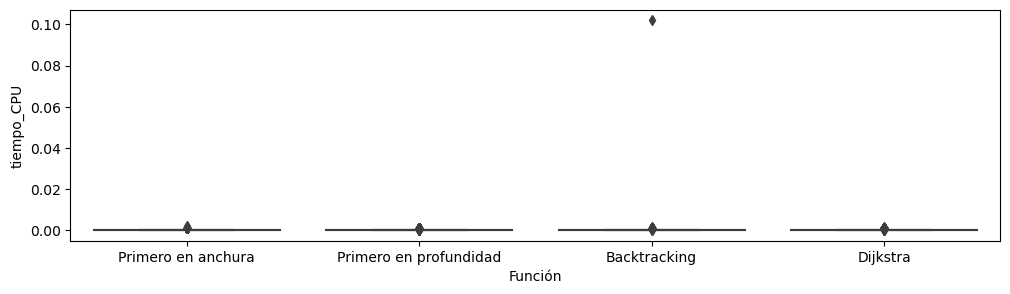

In [21]:
# Plot CPU times
exp.plots(medida='tiempo_CPU')

Este tipo de gráficas no es muy útil. No obstante, si queremos ver el desempeño de los algoritmos con respecto a la complejidad del entorno, las gráficas se vuelven interesantes.

 ### Variando la complejidad del entorno

Veamos primero cómo correr el experimento sobre una serie de entornos que van variando de complejidad. Para este ejercicio tenemos un "test suite", que es una serie de entornos en el viaje a Rumania. La diferencia entre uno y otro es la cantidad de ciudades intermedias que hay que recorrer para llegar desde Arad a la ciudad objetivo.

In [22]:
# Create experiment
exp = Experiment()
# load test_suite
exp.load_test_suite("test_suite_viajerumania.json")
for i, test in enumerate(exp.test_suite):
    print('-'*30)
    print('Test name:', exp.test_suite_names[i])
    print('Start city:', test[0].estado_inicial)
    print('End city:', test[0].ciudad_objetivo)
    print('Number of inbetween cities:', exp.test_suite_pasos[i] - 1)

------------------------------
Test name: vrum_1_1
Start city: Pitesti
End city: Bucharest
Number of inbetween cities: 0
------------------------------
Test name: vrum_1_2
Start city: Pitesti
End city: Craiova
Number of inbetween cities: 0
------------------------------
Test name: vrum_1_3
Start city: Pitesti
End city: Rimnicu Vilcea
Number of inbetween cities: 0
------------------------------
Test name: vrum_2_1
Start city: Pitesti
End city: Giurgiu
Number of inbetween cities: 1
------------------------------
Test name: vrum_2_2
Start city: Pitesti
End city: Urziceni
Number of inbetween cities: 1
------------------------------
Test name: vrum_2_3
Start city: Pitesti
End city: Fagaras
Number of inbetween cities: 1
------------------------------
Test name: vrum_2_2
Start city: Pitesti
End city: Drobeta
Number of inbetween cities: 1
------------------------------
Test name: vrum_2_3
Start city: Pitesti
End city: Sibiu
Number of inbetween cities: 1
------------------------------
Test name

Ahora corremos el experimento, en el cual cada entorno será resuelto por cada uno de los algoritmos:

In [23]:
# Create experiment
exp = Experiment()
# load test_suite
exp.load_test_suite("test_suite_viajerumania.json")
# Create list of search methods
funs = [anchura,
        profundidad,
        lambda problema: backtracking(problema, Nodo(problema.estado_inicial, None, None, 0, problema.codigo(problema.estado_inicial))),
        dijkstra
       ]
nombres = ['Primero en anchura', 
           'Primero en profundidad', 
           'Backtracking',
           'Dijkstra'
          ]
exp.compara_funciones(lista_funs=funs,
                      lista_nombres=nombres, 
                      num_it=5000,
                      lim_steps=10
                      )

Solving state space...:  63%|████████████████████████████████████▋                     | 12/19 [00:24<00:18,  2.67s/it]


Solving state space...: 100%|██████████████████████████████████████████████████████████| 19/19 [00:52<00:00,  2.75s/it]


Y ahora lo que estábamos esperando: las gráficas de las medidas con respecto a las medidas de desempeño.

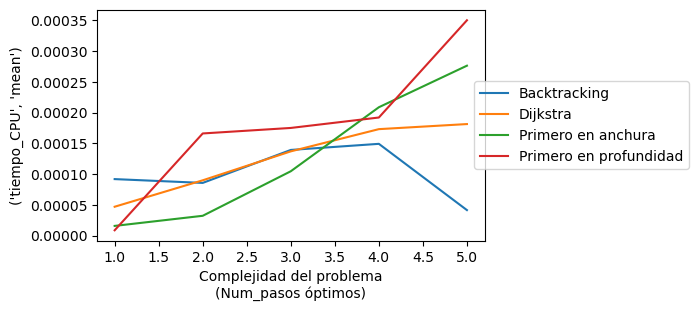

In [24]:
# Plot CPU times
exp.plots(medida='tiempo_CPU')

Se observa un resultado esperado y es que el primero en anchura crece de manera exponencial con la cantidad de pasos. El backtracking tiene un comportamiento aparentemente independiente de esta cantidad. Los otros dos dependen más o menos linealmente con respecto a la cantidad de pasos. 

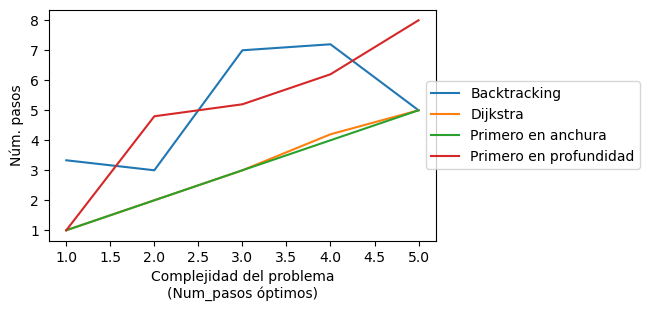

In [25]:
# Plot steps
exp.plots(medida='Num_pasos')

No hay sorpresas aquí. El óptimo en número de ciudades intermedias es el primero en anchura, seguido de Dijkstra. Esto ocurre independientemente de la complejidad del viaje. 

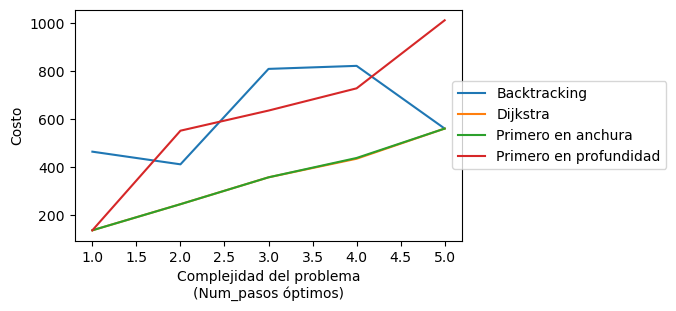

In [26]:
# Plot costs
exp.plots(medida='Costo_camino')

Tampoco hay sorpresas aquí. El óptimo en kilómetros del viaje es el primero en anchura, seguido de Dijkstra. Esto ocurre independientemente de la complejidad del viaje.

<a class="anchor" id="ej3"></a>**Ejercicio 3:** 

([Anterior ejercicio](#ej2)) ([Próximo ejercicio](#ej4))

Utilice el test suite del viaje a Rumania para comparar los métodos `dijkstra` y `avara`. Encuentre:

    1. Tiempos promedio en CPU (use 1000 iteraciones)
    2. Cantidad en kilómetros de la solución.
    
Presente los dos gráficos de líneas con esta información y comente los resultados.

**Nota: ¡No olvide comentar los resultados!**

In [28]:
# Create experiment
exp = Experiment()
# load test_suite
exp.load_test_suite("test_suite_viajerumania.json")
# Create list of search methods
funs = [anchura,
        profundidad,
        lambda problema: backtracking(problema, Nodo(problema.estado_inicial, None, None, 0, problema.codigo(problema.estado_inicial))),
        dijkstra
       ]
nombres = ['Primero en anchura', 
           'Primero en profundidad', 
           'Backtracking',
           'Dijkstra'
          ]
exp.compara_funciones(lista_funs=funs,
                      lista_nombres=nombres, 
                      num_it=5000,
                      lim_steps=10
                      )

Solving state space...:  63%|████████████████████████████████████▋                     | 12/19 [00:25<00:19,  2.77s/it]


Solving state space...: 100%|██████████████████████████████████████████████████████████| 19/19 [00:52<00:00,  2.79s/it]


In [29]:
# Ejercicio 3
# Create experiment
exp = Experiment()
# load test_suite
exp.load_test_suite("test_suite_viajerumania.json")
# Create list of search methods
funs = [dijkstra, 
        lambda problema: avara(problema, problema.heuristica)
       ]
nombres = ['Dijkstra', 
           'Búsqueda Avara'
          ]
# AQUÍ SU CÓDIGO
exp.compara_funciones(lista_funs=funs,
                      lista_nombres=nombres, 
                      num_it=1000,
                      lim_steps=20
                      )
# HASTA AQUÍ SU CÓDIGO

Running algorithm...: 100%|██████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 31.40it/s]

Running algorithm...: 100%|██████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 25.10it/s]

Solving state space...: 100%|██████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  4.18it/s]


---

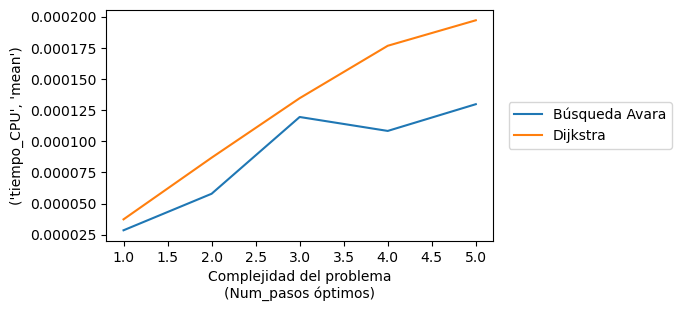

In [30]:
exp.plots(medida='tiempo_CPU')

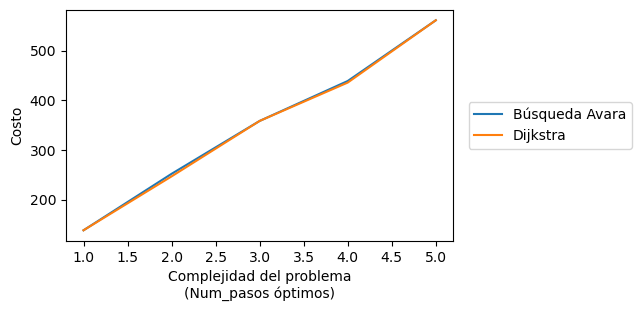

In [31]:
exp.plots(medida='Costo_camino')

## El problema del rompecabezas de 8 piezas <a class="anchor" id="8puzzle"></a>

([Volver al inicio](#inicio))

Considere ocho piezas cuadradas, cada una con un número del 1 al 8. Estas piezas se ponen en una caja cuadrada  formando un rompecabezas, de tal manera que queda un espacio del mismo tamaño que las piezas, como en la figura siguiente:

<img src="./imagenes/puzzle1.png" width="350px"/>

Las piezas adyacentes al espacio pueden desplazarse desde su posición hasta ocupar el espacio vacío, de tal manera que es posible cambiar el orden de todas las piezas. El problema consiste en, dada una posición del rompecabezas, encontrar una manera de mover las piezas para lograr otra posición deseada.

La descripción formal del problema es como sigue:

* **Estado inicial**: Un rompezabezas donde las piezas están dispuestas aleatoriamente.

* **Posibles acciones**: Mover una ficha al espacio vacío. En cada configuración hay maximo cuatro fichas que pueden moverse al espacio vacío (cuando este está en el centro). Usualmente solo pueden moverse tres fichas o solo dos, cuando el espacio vacío está en una esquina. 

* **Función de transiciones**: Mover la ficha y obtener el tablero correspondiente.

* **Prueba de satisfacción del objetivo**: El tablero está organizado como sigue:

<img src="./imagenes/objetivo.png" width="350px"/>

* **Función de costo**: Cada acción cuesta 1 punto.

Observe que podemos usar el método `pintar_camino` para visualizar el movimiento correspondiente de las piezas:

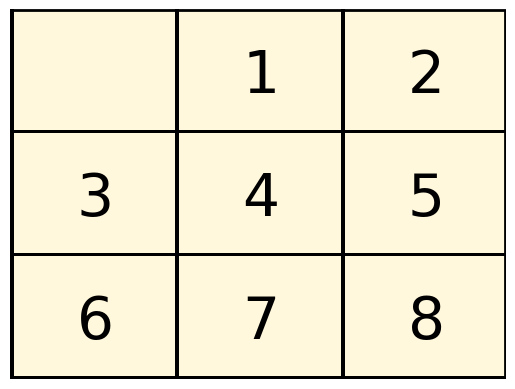

In [35]:
puz = Rompecabezas()
s = np.matrix([[3,1,2], [4,5,8], [0,6,7]])
puz.estado_inicial = s
camino = [ ((1, 2), (0, 2)),((2, 2), (1, 2)), ((2, 1), (2, 2)), ((1, 1), (2, 1)), ((0, 1), (1, 1)), ((0, 0), (0, 1))]
puz.pintar_camino(camino)

El problema del rompecabezas es difícil, y usualmente le cuesta un buen tiempo a los métodos de `primero en anchura` y `primero en profundidad` converger a una solución. El algoritmo de `dijkstra`, usando una función de costo en términos del número de movimientos, es exáctamente igual al primero en anchura.

Vamos a hacer la comparación de primero en anchura y primero en profundidad usando un test suite creado de la siguiente manera. Los estados iniciales de los primeros entornos se obtienen a partir del estado final, moviendo alguna ficha. Luego estos se modifican moviendo otra ficha (evitando repeticiones) y se repite el proceso. Observe que estos entornos se pueden ordenar en términos de complejidad, entendida esta como la cantidad de movimientos que se requieren para obtener el estado final.

In [43]:
# Create experiment
exp = Experiment()
# load test_suite
exp.load_test_suite("test_suite_rompecabezas.json")
# Create list of search methods
funs = [anchura,
        profundidad,
       ]
nombres = ['Primero en anchura', 
           'Primero en profundidad',
          ]
data = exp.compara_funciones(lista_funs=funs,
                             lista_nombres=nombres, 
                             num_it=5,
                             lim_steps=1
                            )

Running algorithm...: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 164.81it/s]

Solving state space...: 100%|██████████████████████████████████████████████████████| 421/421 [00:00<00:00, 8469.68it/s]


Observe que hemos limitado la complejidad del problema a solo 1, mediante la opción`lim_steps=1` en el método `compara_funciones()`.

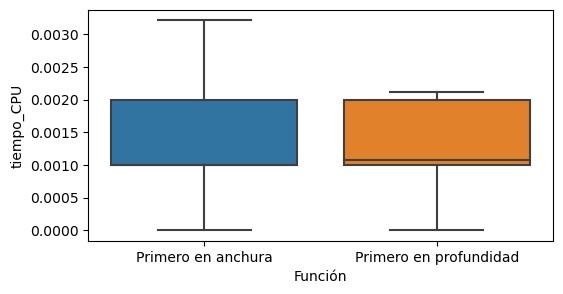

In [44]:
# Plot CPU times
exp.plots(medida='tiempo_CPU')

Se observa que el algoritmo primero en profundidad es el que más toma tiempo para encontrar una solución. Esto probablemente se debe a que hay muchos movimientos de fichas que llevan a estados diferentes, sin ningún acercamiento al estado final.

Corramos solo el algoritmo de primero en anchura para ver su desempeño sobre una cantidad de rompecabezas más complejos. Vamos a cambiar la opción `lim_steps` a 5.

In [45]:
# Create experiment
exp = Experiment()
# load test_suite
exp.load_test_suite("test_suite_rompecabezas.json")
# Create list of search methods
funs = [anchura
       ]
nombres = ['Primero en anchura'
          ]
data = exp.compara_funciones(lista_funs=funs,
                             lista_nombres=nombres, 
                             num_it=5,
                             lim_steps=5
                            )

Running algorithm...: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 166.65it/s]

Running algorithm...: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 89.99it/s]

Running algorithm...: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 89.86it/s]

Running algorithm...: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.58it/s]

Running algorithm...: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.46it/s]

Running algorithm...: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.37it/s]

Running algorithm...: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.65it/s]

Running algorithm...: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.12it/s]

Running algorithm...: 100%|█████

Solving state space...: 100%|████████████████████████████████████████████████████████| 421/421 [00:08<00:00, 51.76it/s]


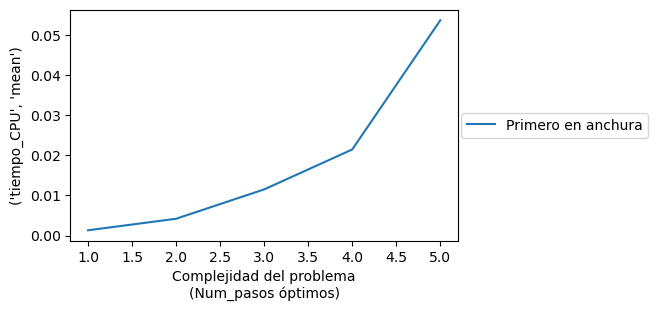

In [46]:
# Plot CPU times
exp.plots(medida='tiempo_CPU')

Los tiempos en CPU presentan una hermosa curva exponencial con respecto a la complejidad del rompecabezas. Si usted corrió la celda anterior, pudo notar que el tiempo de procesamiento fue sustancial. Surge la pregunta: ¿podemos resolver el rompecabezas de manera más eficiente?

## Heurísticas para el 8 puzzle <a class="anchor" id="heuristicas"></a>

([Volver al inicio](#inicio))

Recordemos que el propósito de una heurística es ayudarnos a dar un estimado del costo desde un estado dado hasta la solución del problema. El problema del rompecabezas nos permite considerar distintas heurísticas. Podemos evaluar una especie de distancia entre un estado dado y el estado objetivo mediante el conteo de piezas que no se encuentran en el lugar objetivo. Por ejemplo, considere el siguiente tablero:

<Axes: >

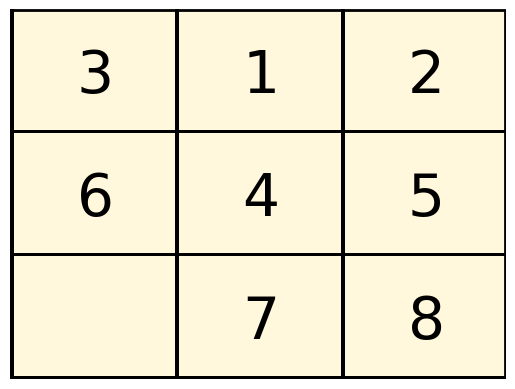

In [47]:
puz = Rompecabezas()
s = np.matrix([[3,1,2], [6,4,5], [0,7,8]])
puz.render(s)

En este tablero hay dos piezas que no están en la posición objetivo, a saber, el 3 y el 6. Por lo tanto, la función heurística `piezas_mal_puestas` debe devolver el valor 2.

<a class="anchor" id="ej4"></a>**Ejercicio 4:** 

([Anterior ejercicio](#ej3)) ([Próximo ejercicio](#ej5))

Implemente la función `piezas_mal_puestas`.

**Nota: Para facilidad de la implementación, asuma que el espacio vacío es una pieza.**

La respuesta de la siguiente celda debe ser:
```
Número de piezas mal puestas de s1: 3
Número de piezas mal puestas de s2: 6
Número de piezas mal puestas de s3: 7
```

In [57]:
(s1 != puz.objetivo).sum()

3

Número de piezas mal puestas de s1: 3
Número de piezas mal puestas de s2: 6
Número de piezas mal puestas de s3: 7


<Axes: >

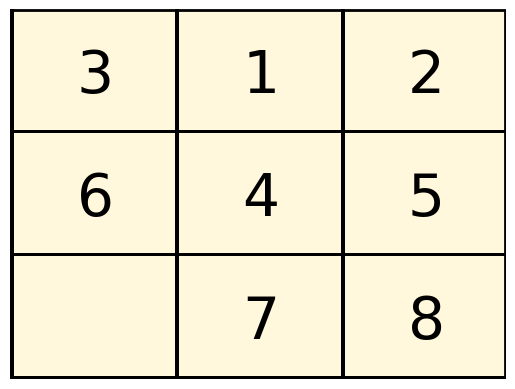

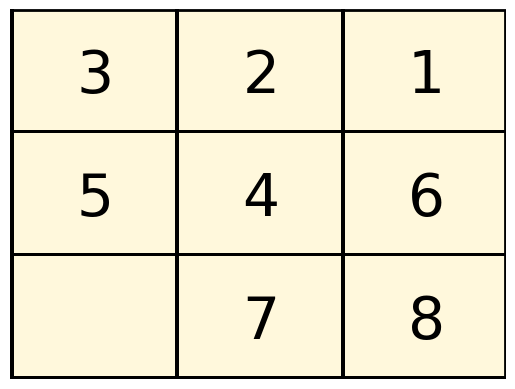

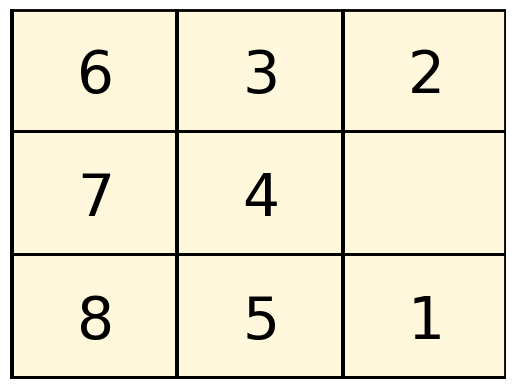

In [58]:
# Ejercicio 4
def piezas_mal_puestas(self, estado:np.matrix) -> int:
    '''
    Devuelve el número de piezas mal puestas.
    Debe ser implementado como el método de una clase.
    Input:
        - estado, que es una matriz con el estado a evaluar
    Output:
        - entero con el número de piezas mal puestas
    '''
    

    objetivo = self.objetivo

    # COMIENCE AQUÍ SU CÓDIGO
    return (estado != objetivo).sum()
    # AQUÍ TERMINA SU CÓDIGO

# Incluimos el método en la clase
setattr(Rompecabezas, 'piezas_mal_puestas', piezas_mal_puestas)
# Instanciamos la clase con el problema del rompecabezas
puz = Rompecabezas()
# Hacemos las comprobaciones
s1 = np.matrix([[3,1,2], [6,4,5], [0,7,8]])
puz.render(s1)
print('Número de piezas mal puestas de s1:', puz.piezas_mal_puestas(s1))
s2 = np.matrix([[3,2,1], [5,4,6], [0,7,8]])
puz.render(s2)
print('Número de piezas mal puestas de s2:', puz.piezas_mal_puestas(s2))
s3 = np.matrix([[6, 3, 2], [7, 4, 0], [8, 5, 1]])
print('Número de piezas mal puestas de s3:', puz.piezas_mal_puestas(s3))
puz.render(s3)

---

Otra heurística para el problema del rompecabezas es el siguiente. La distancia entre un estado y el objetivo se mide como la suma de las distancias entre cada pieza y su lugar objetivo. Esta última distancia se mide como la distancia del taxista, es decir, la suma de las distancias verticales y horizontales. Por ejemplo, suponga el siguiente estado:

<Axes: >

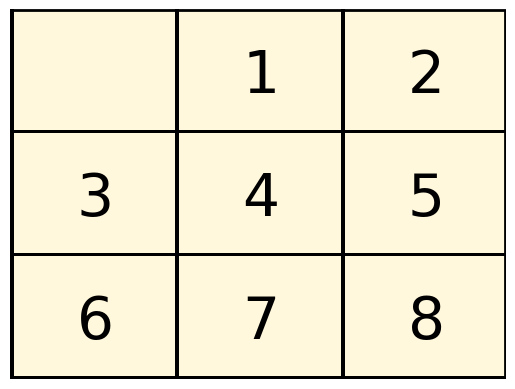

In [62]:
a=puz.objetivo
puz.render(a)

<Axes: >

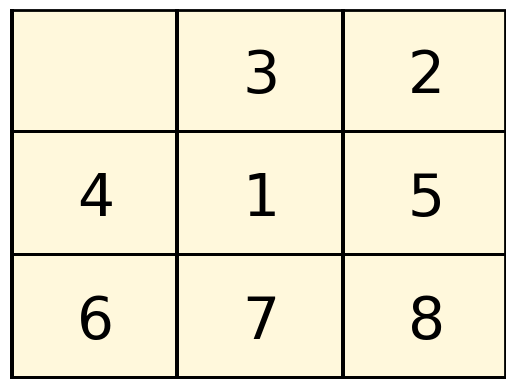

In [63]:
puz = Rompecabezas()
s = np.matrix([[0,3,2], [4,1,5], [6,7,8]])
puz.render(s)

Observe que el 1 está a una casilla de su lugar (una abajo), el cuatro está a una casilla de su lugar (una a la izquierda) y el 3 está a dos casillas de su lugar (una arriba y una a la derecha. El valor de la heurística `manhattan` debe ser 1 + 1 + 2 = 4. 

<a class="anchor" id="ej5"></a>**Ejercicio 5:** 

([Anterior ejercicio](#ej4)) ([Próximo ejercicio](#ej6))

Implemente la función `manhattan`.

**Nota: Para facilidad de la implementación, asuma que el espacio vacío es una pieza.**

La respuesta debe ser:

```
Distancia Manhattan de s1: 4
Distancia Manhattan de s2: 10
Distancia Manhattan de s3: 16
```

In [ ]:
# Ejercicio 5
def manhattan(self, estado:np.matrix) -> int:
    '''
    Devuelve la suma de la distancia Manhattan de las piezas 
    respecto a su lugar objetivo en el rompecabezas.
    Debe ser implementado como el método de una clase.
    Input:
        - estado, que es una matriz con el estado a evaluar
    Output:
        - entero con la distancia Manhattan
    '''
    pass

    objetivo = self.objetivo

    # COMIENCE AQUÍ SU CÓDIGO

    # AQUÍ TERMINA SU CÓDIGO

# Incluimos el método en la clase
setattr(Rompecabezas, 'manhattan', manhattan)
# Instanciamos la clase con el problema del rompecabezas
puz = Rompecabezas()
# Hacemos las comprobaciones
s1 = np.matrix([[3,1,2], [6,4,5], [0,7,8]])
puz.render(s1)
print('Distancia Manhattan de s1:', puz.manhattan(s1))
s2 = np.matrix([[3,2,1], [5,4,6], [0,7,8]])
puz.render(s2)
print('Distancia Manhattan de s2:', puz.manhattan(s2))
s3 = np.matrix([[6, 3, 2], [7, 4, 0], [8, 5, 1]])
print('Distancia Manhattan de s3:', puz.manhattan(s3))
puz.render(s3)

---

## Comparando heurísticas <a class="anchor" id="compara"></a>

([Volver al inicio](#inicio))

Al ordenar los nodos explorados mediante una función heurística, lo que se busca es explorar primero aquel nodo que se acerque más al objetivo. Hemos definido dos maneras de estimar esta idea y es hora de compararlas mediante el tiempo de CPU.

<a class="anchor" id="ej6"></a>**Ejercicio 6:** 

([Anterior ejercicio](#ej5)) ([Próximo ejercicio](#ej7))

Compare el tiempo de CPU de las dos heurísticas en el algoritmo de búsqueda `avara` e incluya el algoritmo de primero en anchura. ¿Cuál tiene mejor tiempo de búsqueda? 

Use los siguientes parámetros:

* `num_it=5`
* `lim_steps=4`

**Nota: ¡No olvide comentar los resultados!**

In [ ]:
# Ejercicio 6
# Create experiment
exp = Experiment()
# load test_suite
exp.load_test_suite("test_suite_rompecabezas.json")
# Create functions and their names
nombres = ['Primero en anchura',
           'Piezas mal puestas', 
           'Manhattan']
# COMIENCE AQUÍ SU CÓDIGO

# AQUÍ TERMINA SU CÓDIGO

In [ ]:
nombres = ['Primero en anchura', 'Piezas mal puestas', 'Manhattan']
for nombre in nombres:
    values = exp.data[exp.data['Función'] == nombre]['Costo_camino'].tolist()
    assert(len([x for x in values if x is None]) == 0), f'Error de resultados {nombre}. Revisar implementación.'
print('¡Todos los tests superados!')

---

## Algoritmo A$^*$ <a class="anchor" id="a_star"></a>

([Volver al inicio](#inicio))

Ahroa veremos el algoritmo A$^*$, el cual es una forma de Best First Search. En este caso, la evaluación $f$ de los nodos se hace mediante la suma entre su costo_camino $g$ y una heurística $h$ que estima el costo mínimo desde el nodo hasta la solución.

$$f(n) = g(n) + h(n)$$

El siguiente es el pseudocódigo del algoritmo A$^*$:

<div style="background-color:rgba(0, 0, 0, 0.0470588); padding:10px 0;font-family:monospace;">
<font style="font-weight: bold;" color = "red">function</font> A_star(<font style="font-style: italic;">problema</font>, <font style="font-style: italic;">heuristica</font>) <font style="font-weight: bold;" color = "red">returns</font> <font style="font-style: italic;">nodo</font> o falla <br>
&nbsp;&nbsp; <font style="font-style: italic;">s</font> &#8592; <font style="font-style: italic;">problema</font>.estado_inicial <br>
&nbsp;&nbsp; <font style="font-style: italic;">v</font> &#8592; <font style="font-style: italic;">heuristica</font>(<font style="font-style: italic;">s</font>) <br>
&nbsp;&nbsp; <font style="font-style: italic;">cod</font> &#8592; <font style="font-style: italic;">problema</font>.codigo(<font style="font-style: italic;">s</font>) <br>
&nbsp;&nbsp; <font style="font-style: italic;">nodo</font> &#8592; NODO(<font style="font-style: italic;">s</font>) <br>
&nbsp;&nbsp; <font style="font-style: italic;">frontera</font> &#8592; lista prioritaria con 1 item con key <font style="font-style: italic;">nodo</font> y valor v<br>
&nbsp;&nbsp; <font style="font-style: italic;">explorados</font> &#8592; diccionario con 1 item con key <font style="font-style: italic;">cod</font> y valor v <br>
&nbsp;&nbsp; <font style="font-weight: bold;" color = "red">While not</font> VACIA(<font style="font-style: italic;">frontera</font>) <font style="font-weight: bold;" color = "red">do</font> <br> 
&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-style: italic;">nodo</font> &#8592; POP(<font style="font-style: italic;">frontera</font>) <br>
&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-weight: bold;" color = "red">if</font> <font style="font-style: italic;">problema</font>.test_objetivo(<font style="font-style: italic;">nodo</font>.estado) <font style="font-weight: bold;" color = "red">then return</font> <font style="font-style: italic;">nodo</font> <br>
&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-weight: bold;" color = "red">for each</font> <font style="font-style: italic;">accion</font> <font style="font-weight: bold;" color = "red">in</font> <font style="font-style: italic;">problema</font>.acciones_aplicables(<font style="font-style: italic;">nodo</font>.estado) <font style="font-weight: bold;" color = "red">do</font> <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-style: italic;">hijo</font> &#8592; nodo_hijo(<font style="font-style: italic;">problema</font>, <font style="font-style: italic;">nodo</font>, <font style="font-style: italic;">accion</font>) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-style: italic;">s</font> &#8592; <font style="font-style: italic;">hijo</font>.estado<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-style: italic;">v</font> &#8592; <font style="font-style: italic;">heuristica</font>(<font style="font-style: italic;">s</font>) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-style: italic;">cod</font> &#8592; <font style="font-style: italic;">hijo</font>.codigo <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-style: italic;">c</font> &#8592; <font style="font-style: italic;">hijo</font>.costo_camino <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-style: italic;">h</font> &#8592; <font style="font-style: italic;">v</font> + <font style="font-style: italic;">c</font><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-weight: bold;" color = "red">if</font> <font style="font-style: italic;">cod</font> <font style="font-weight: bold;" color = "red">not in</font> <font style="font-style: italic;">explorados</font>.keys <font style="font-weight: bold;" color = "red">or</font> <font style="font-style: italic;">h</font> &#60; <font style="font-style: italic;">explorados</font>[<font style="font-style: italic;">cod</font>] <font style="font-weight: bold;" color = "red">then</font> <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ADD((<font style="font-style: italic;">hijo</font>, <font style="font-style: italic;">h</font>), <font style="font-style: italic;">frontera</font>) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-style: italic;">explorados</font>[<font style="font-style: italic;">cod</font>] &#8592; <font style="font-style: italic;">h</font> <br>
    &nbsp;&nbsp; <font style="font-weight: bold;" color = "red">return</font> falla <br>
</div>

**$A^*$ con pesos**

Una versión más poderosa del algoritmo $A^*$ es el llamado $A^*$ con pesos, en el cual la función de evaluación incluye una modificación del término heurístico por un factor $W$, de la siguiente manera:

$$f(n) = g(n) + W\times h(n)$$

donde $W > 1$. Esto significa que la función de evaluación da mayor peso al estimado de la función heurística, sin dejar de considerar el costo camino.

<a class="anchor" id="ej7"></a>**Ejercicio 7:** 

([Anterior ejercicio](#ej6))  ([Próximo ejercicio](#ej8))

Para resolver este ejercicio debe realizar lo siguiente:

1. Implementar el algoritmo $A^*$ con pesos. Un parámetro de la función debe ser el peso `W`.
2. Realizar un experimento de tiempos de CPU que compare el desempeño de $A^*$ con heurística manhatta, para dos valores de `W`: 1 y 3. Para este experimento use los siguientes parámetros: `num_it=5`, `lim_steps=7`.
3. Crear una gráfica de los resultados y comentar. ¿Cuál es el mejor valor para `W` en este problema?

In [ ]:
# Ejercicio 7a
def A_star(problema, heuristica, W):
    pass
    # AQUÍ SU CÓDIGO
    
    # HASTA AQUÍ SU CÓDIGO

In [ ]:
# Ejercicio 7b
# Create experiment
exp = Experiment()
# load test_suite
exp.load_test_suite("test_suite_rompecabezas.json")
# Create functions and their names
Ws = ...
nombres = [f'W={w}' for w in Ws]
funs = [lambda puz: A_star(puz, manhattan, W=w) for w in Ws]
...

## En este notebook usted aprendió

([Volver al inicio](#inicio))

* Cómo realizar una búsqueda mediante el algoritmo de Dijkstra, la búsqueda avara y el algoritmo $A^*$.
* Implementar y comparar distintas heurísticas para resolver el problema del rompecabezas.